This notebook creates a set of 8 naive templates, plots the matched photometry, trains the templates, and then makes plots of the results and the training process.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle, copy
from scipy.interpolate import interp1d

from modules.galaxyphoto import get_bandpass_dict, Sed
from modules.photomatching import create_training_sets
from modules.training import new_naive_templates, train_templates

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

Load the filters

In [3]:
bandpass_dict = get_bandpass_dict()

Load the galaxy redshift catalog

In [4]:
with open('data/training_catalog.pkl', 'rb') as input:
    galaxies = pickle.load(input)

Create the naive templates

In [5]:
def log_norm(x,mode,sigma):
    mu = np.log(mode) + sigma**2
    f1 = lambda x: 1/(x*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-mu)**2/(2*sigma**2))
    return f1(x)/f1(5000)

N = 8
n = 3
modes  = np.concatenate((np.linspace(5500,4600,n,endpoint=False),np.linspace(4600,1000,N-n)))
sigmas = np.concatenate((np.linspace(0.35,0.56,n,endpoint=False),np.linspace(0.56, 0.9,N-n)))

# save the templates as Seds
x = np.arange(10,15000,100,dtype=float)
naive_templates = dict()
for i in range(N):
    template = Sed()
    template.wavelen = x
    template.flambda = log_norm(x,modes[i],sigmas[i])
    naive_templates["N8-"+str(i+1)] = template
    
del N,n,modes,sigmas,x,i,template

Create training sets and plot them

In [6]:
%%time
training_sets = create_training_sets(galaxies, naive_templates, bandpass_dict)

CPU times: user 9.36 s, sys: 678 ms, total: 10 s
Wall time: 48.1 s


Number of galaxies in each training set:
[15431, 12380, 10966, 13897, 12513, 4699, 5796, 6298]


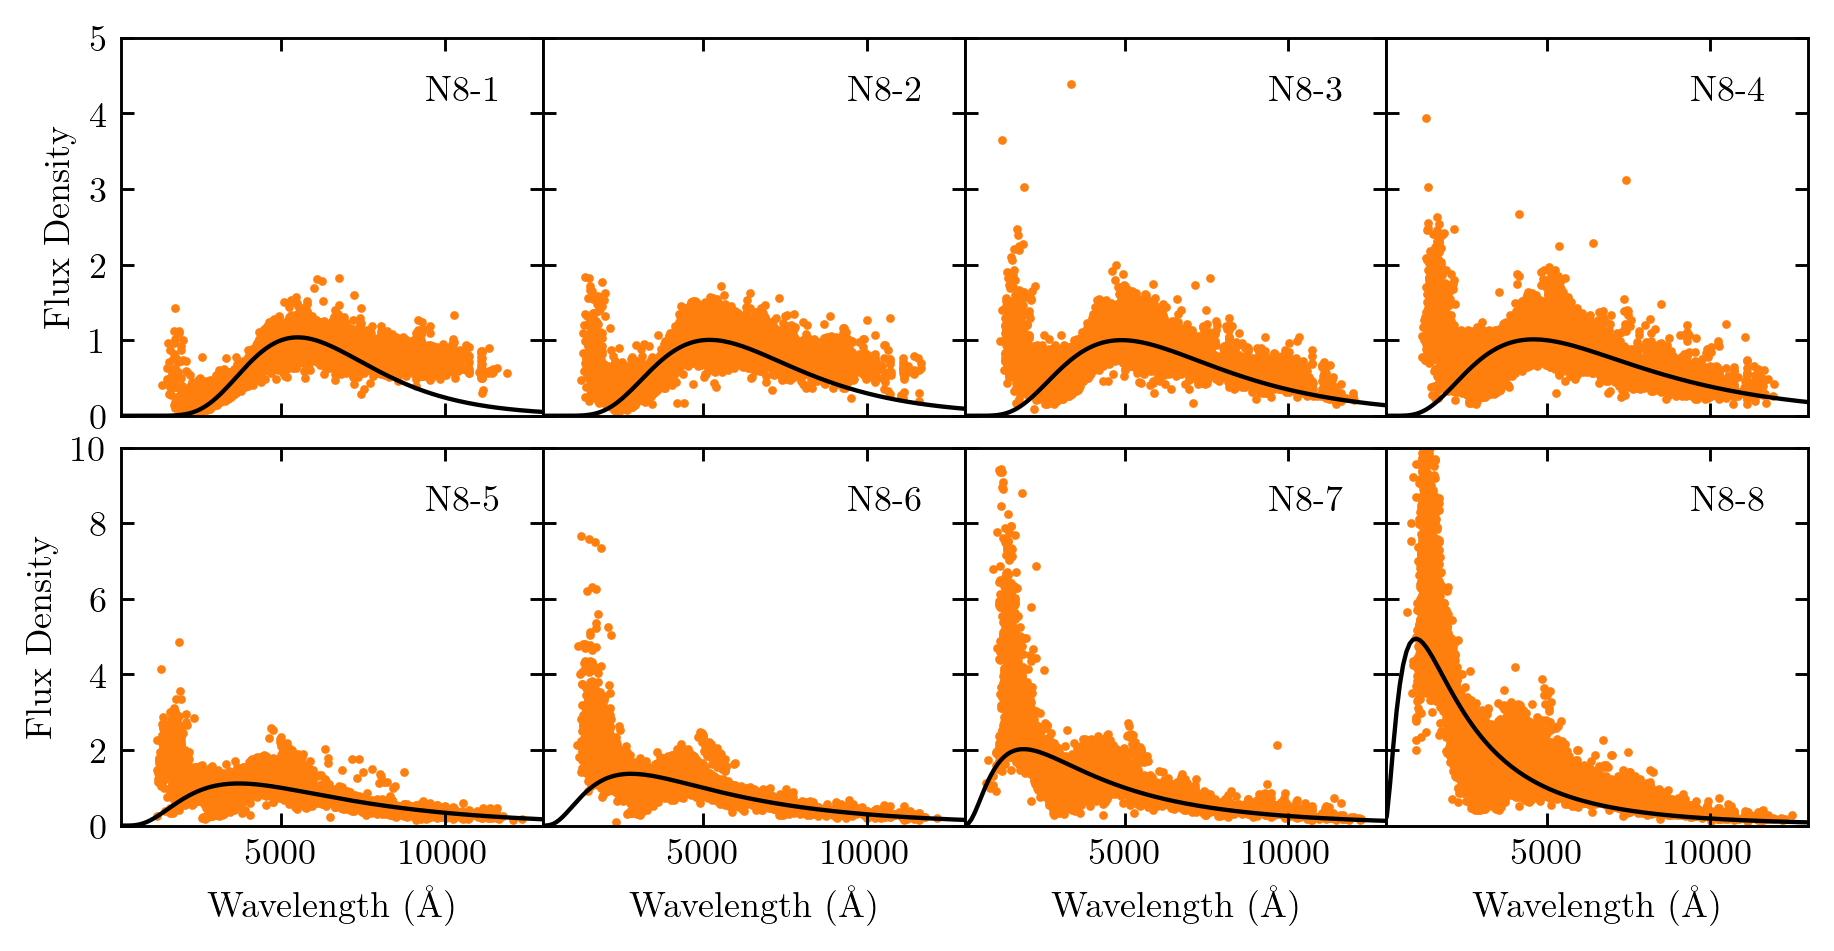

In [7]:
ncols = 4
nrows = 2
fig, axes = plt.subplots(nrows,ncols,sharex='all',sharey='row',figsize=(twocol,twocol*nrows/ncols))

print("Number of galaxies in each training set:")
print([len(i) for i in training_sets.values()])

for key,ax in zip(training_sets.keys(),axes.flatten()):
    
    tset = training_sets[key]
    wavelen = [w for galaxy in tset for w in galaxy.wavelen]
    fluxes = [f for galaxy in tset for f in galaxy.fluxes]
    ax.scatter(wavelen, fluxes, s=2, c="C1")
    del tset, wavelen, fluxes
    
    template = naive_templates[key]
    ax.plot(template.wavelen, template.flambda, c="k")
    
    ax.text(0.9,0.9,key,transform=ax.transAxes,ha="right",va="top")
    
    ax.set_xlim(100,13000)

axes[0,0].set_ylim(0,5)
axes[1,0].set_ylim(0,10)

for ax in axes[-1,:]:
    ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
for ax in axes[:,0]:
    ax.set_ylabel('Flux Density')
    
fig.tight_layout(pad=0.5, h_pad=0, w_pad=0)
plt.show()

#fig.savefig('plots/N8_untrained.png')

Now train the templates.

In [9]:
%%time
trained_templates, history = train_templates(galaxies, naive_templates, bandpass_dict, w=0.5, dmse_stop=0.04)

Columns: Template, number of perturbations, initial/final wMSE
Round 1
N8-1      4       64.7       30.5
N8-2      3       97.1       58.3
N8-3      3       85.7       60.4
N8-4      3       88.2       61.6
N8-5      3       98.5       60.4
N8-6      3      259.8      157.4
N8-7      3      526.9      296.8
N8-8      2     1519.4      892.1
Round 2
N8-1      2       32.5       28.4
N8-2      2       48.4       41.4
N8-3      2       41.4       37.1
N8-4      2       39.5       36.2
N8-5      2       31.1       28.7
N8-6      2       75.4       67.6
N8-7      0      301.7      301.7
N8-8      2      653.3      550.4
Round 3
N8-1      0       29.4       29.4
N8-2      0       41.1       41.1
N8-3      2       39.3       36.3
N8-4      1       33.1       31.9
N8-5      2       33.7       32.2
N8-6      2       60.2       56.8
N8-7      2      134.5      120.5
N8-8      1      848.7      816.7
Round 4
N8-1      0       29.2       29.2
N8-2      0       42.4       42.4
N8-3      2       42.

Generate the training sets for these final templates, for plotting purposes

In [10]:
final_sets = create_training_sets(galaxies, trained_templates, bandpass_dict)

Save the results!

In [ ]:
"""for template in trained_templates:
    file = open('templates/'+template+'.sed','w')
    x = trained_templates[template].wavelen
    y = trained_templates[template].flambda
    for i in range(len(x)):
        file.write("{0:<10.2f}{1:<10.4f}\n".format(x[i],y[i]))
    file.close()
    
f = open("templates/N8_training_history.pkl","wb")
pickle.dump(history,f)
f.close()""";

OR load the results if you didn't just run the training.

In [6]:
trained_templates = dict()
for template in naive_templates:
    x,y = np.loadtxt('templates/'+template+'.sed',unpack=True)
    trained_templates[template] = Sed(x,y)
    
final_sets = create_training_sets(galaxies, trained_templates, bandpass_dict)

with open('templates/N8_training_history.pkl', 'rb') as input:
    history = pickle.load(input)

Plot the trained templates

Number of galaxies in each training set:
[10703, 9401, 8473, 10513, 13192, 14355, 11117, 4226]


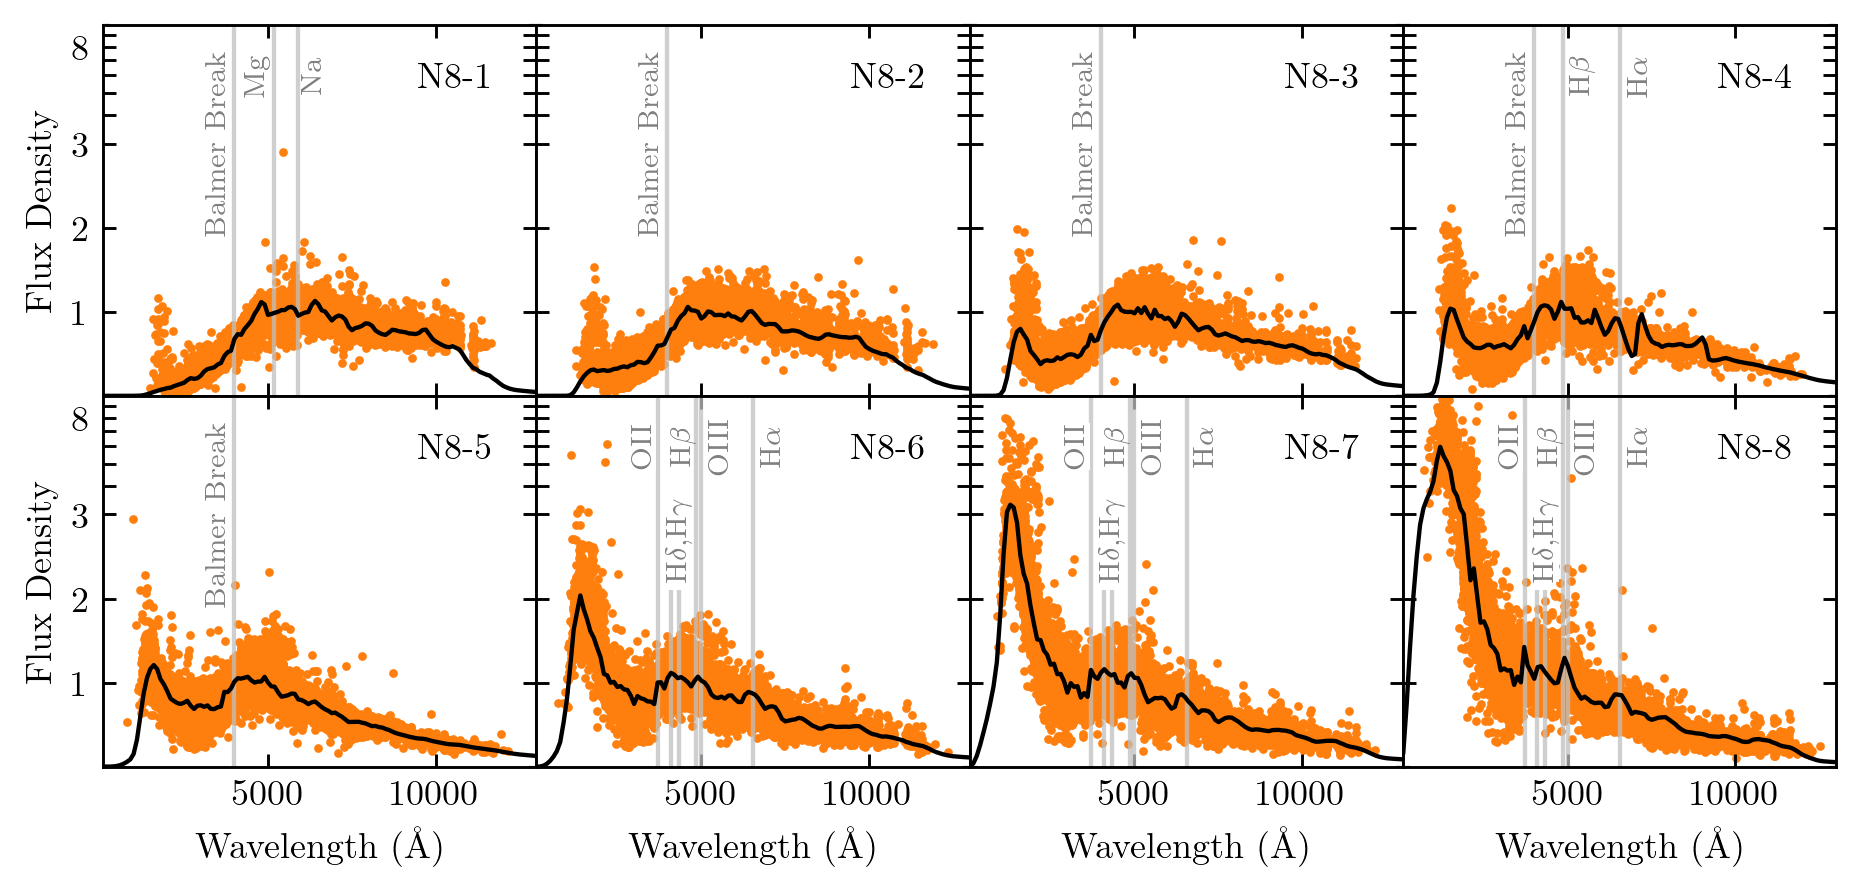

In [12]:
ncols = 4
nrows = int(len(trained_templates)/ncols+0.5)
fig, axes = plt.subplots(nrows,ncols,sharex='all',sharey='row',figsize=(twocol,twocol*nrows/ncols*0.95))

print("Number of galaxies in each training set:")
print([len(i) for i in final_sets.values()])

for key,ax in zip(final_sets.keys(),axes.flatten()):
    
    tset = final_sets[key]
    wavelen = [w for galaxy in tset for w in galaxy.wavelen]
    fluxes = [f for galaxy in tset for f in galaxy.fluxes]
    ax.scatter(wavelen, fluxes, s=2, c="C1")
    del tset, wavelen, fluxes
    
    template = trained_templates[key]
    ax.plot(template.wavelen, template.flambda, c="k")
    
    ax.text(0.9,0.9,key,transform=ax.transAxes,ha="right",va="top")
    

# Feature lines
axes_ = axes.flatten()
box_style = dict(facecolor='white', edgecolor='none', pad=0)
# Lyman Break
for i in [1,2,3,4,5]:
    axes_[i-1].vlines(4000,0,10,color='silver',alpha=0.75) # Lyman Break
    axes_[i-1].text(3900,3,"Balmer Break",fontsize=8,rotation=90,
                    color='gray',ha='right',va='center',bbox=box_style)
# Mg and Na absorption
for i in [1]:
    axes_[i-1].vlines(5175,0,10,color='silver',alpha=0.75) # Mg
    axes_[i-1].text(5075,6,"Mg",fontsize=8,rotation=90,
                    color='gray',ha='right',va='center',bbox=box_style)
    axes_[i-1].vlines(5894,0,10,color='silver',alpha=0.75) # Na
    axes_[i-1].text(5994,6,"Na",fontsize=8,rotation=90,
                    color='gray',ha='left',va='center',bbox=box_style)
# Halpha
for i in [4,6,7,8]:
    axes_[i-1].vlines(6563,0,10,color='silver',alpha=0.75) # Halpha
    axes_[i-1].text(6763,6,r"H$\alpha$",fontsize=8,rotation=90,
                    color='gray',ha='left',va='center',bbox=box_style)
# Hbeta
for i in [4]:    
    axes_[i-1].vlines(4861,0,10,color='silver',alpha=0.75) # Hbeta
    axes_[i-1].text(5061,6,r"H$\beta$",fontsize=8,rotation=90,
                    color='gray',ha='left',va='center')    
for i in [6,7,8]:    
    axes_[i-1].vlines(4861,0,10,color='silver',alpha=0.75) # Hbeta
    axes_[i-1].text(4861,6,r"H$\beta$",fontsize=8,rotation=90,
                    color='gray',ha='right',va='center')
# OIII
for i in [6,7,8]:
    axes_[i-1].vlines(5007,0,10,color='silver',alpha=0.75) # OIII
    axes_[i-1].text(5207,6,"OIII",fontsize=8,rotation=90,
                    color='gray',ha='left',va='center')
# OII
for i in [6,7,8]:
    axes_[i-1].vlines(3727,0,10,color='silver',alpha=0.75) # OII
    axes_[i-1].text(3677,6,"OII",fontsize=8,rotation=90,
                    color='gray',ha='right',va='center',bbox=box_style)
# Hdelta and Hgamma
for i in [6,7,8]:
    axes_[i-1].vlines(4102,0,2.1,color='silver',alpha=0.75) # Hdelta
    axes_[i-1].vlines(4340,0,2.1,color='silver',alpha=0.75) # Hgamma
    axes_[i-1].text(4352,2.2,r"H$\delta$,H$\gamma$",fontsize=8,rotation=90,
                    color='gray',ha='center',va='bottom',bbox=box_style)


for ax in axes[-1,:]:
    ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
    ax.set_xlim(100,13000)
for ax in axes[:,0]:
    ax.set_ylabel('Flux Density')
    ax.set_yscale('symlog',linthreshy=3)
    ax.set_ylim(0,10)
    ax.set_yticks([1,2,3,4,5,6,7,8,9])
    ax.set_yticklabels([1,2,3,'','','','',8,''])
    
fig.tight_layout(pad=0.5, h_pad=0, w_pad=0)
plt.show()

#fig.savefig('plots/N8_trained.png')

Plots of the training history

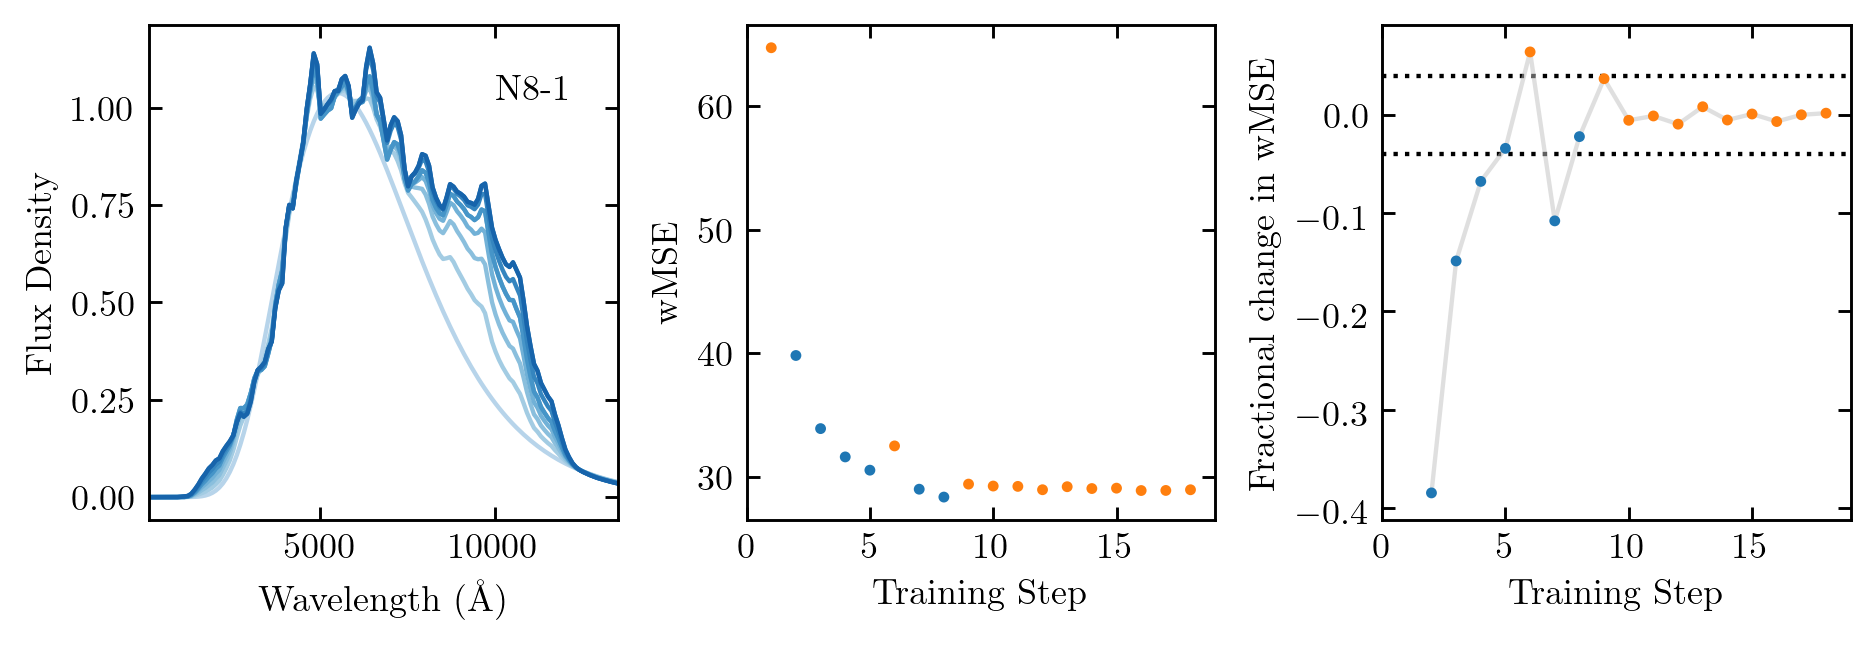

In [34]:
template = "N8-1"

seds = []
mse = []
colors = []

for Round in history[template].values():
    seds.extend(Round[0])
    mse.extend(Round[1])
    colors.append('C1')
    for i in range(len(Round[0])-1):
        colors.append('C0')

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(twocol,twocol/3),constrained_layout=True)

seds = seds[:9]
color_idx = np.linspace(0.3,0.8,len(seds))
for i,sed in enumerate(seds):
    ax1.plot(sed.wavelen, sed.flambda, c=plt.cm.Blues(color_idx[i]))
    
ax1.text(0.9,0.9,template,transform=ax1.transAxes,ha="right",va="top")

x = np.arange(1,len(mse)+1)
ax2.scatter(x, mse, c=colors)

x = np.arange(1,len(mse)) + 1
dmse = [(mse[i+1]-mse[i])/mse[i] for i in range(len(x))]
ax3.scatter(x, dmse, color=colors[1:])
ax3.plot(x, dmse, c='silver',zorder=0,alpha=0.5)
ax3.hlines(0.04,0,max(x)+1,color='k',zorder=0,ls=':')
ax3.hlines(-0.04,0,max(x)+1,color='k',zorder=0,ls=':')

ax1.set_xlim(100,13500)
ax1.set_xlabel("Wavelength (\AA)")
ax1.set_ylabel("Flux Density")

ax2.set_xlim(0,max(x)+1)
ax2.set_xlabel('Training Step')
ax2.set_ylabel('wMSE')

ax3.set_xlim(0,max(x)+1)
ax3.set_xlabel('Training Step')
ax3.set_ylabel('Fractional change in wMSE')

#fig.savefig('plots/N8_1_training_history.pdf')
plt.show()